# Generate Plots and Table of Potential Observables for Constraining FSI Model Uncertainties
The code is generalized to produce plots with corresponding chi squared values for any weight, particle, and kinematic.

In [68]:
# Import Statements
import numpy as np
import pandas as pd
from particle import Particle
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import chisquare

# Plotting Settings
%matplotlib inline
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'small',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small', 
         'lines.markersize': 10}
pylab.rcParams.update(params)

In [46]:
######################################################################
############################ ARCHIEVE ################################
######################################################################

## Read in necessary dataframes (fp: final particles, ip: initial particles, sm all other columns) ##
#gst_fp_df = pd.read_hdf("/Users/laurazichi/Desktop/Fermilab/base_generation_with_weights_13Jun_FSIFix.hdf", "gst_fp_df")
#gst_ip_df = pd.read_hdf("/Users/laurazichi/Desktop/Fermilab/base_generation_with_weights_13Jun_FSIFix.hdf", "gst_ip_df")
#gst_df = pd.read_hdf("/Users/laurazichi/Desktop/Fermilab/base_generation_with_weights_13Jun_FSIFix.hdf", "gst_df")

In [5]:
######################################################################
############################ ARCHIEVE ################################
######################################################################

lep_df = pd.read_hdf("lep_cut_df.hdf")
df_all = pd.read_hdf('piNP_all.hdf', 'piNP')

df_all_cuts = pd.read_hdf('piNP_all_cuts.hdf', 'piNP_cuts')
df_all_cuts = df_all_cuts.join(lep_df[wghts], on= 'event', how = 'inner')

# Take out zeros
df_all = df_all.query('ke_211_l != 0')
df_all_cuts = df_all_cuts.query('ke_211_l != 0')

# Add weights
df_all = df_all.join(lep_df[wghts], on= 'event', how = 'inner')
gst_fp_df = gst_fp_df.join(gst_df[wghts],on='entry')
print('orginal:', np.shape(gst_fp_df), np.shape(np.unique(gst_fp_df.index.get_level_values(0))))

# Final state lepton pt cut greater than 400 MeV
gst_df["ptl"] = np.sqrt(gst_df["pxl"]*gst_df["pxl"]+gst_df["pyl"]*gst_df["pyl"])
gst_fp_df = gst_fp_df.join(gst_df["ptl"],on='entry').query("ptl>0.4")
gst_ip_df = gst_ip_df.join(gst_df["ptl"],on='entry').query("ptl>0.4")
print('Lepton pt cut:', np.shape(gst_fp_df), np.shape(np.unique(gst_fp_df.index.get_level_values(0))))

# Zero cut
gst_fp_df = gst_fp_df[gst_fp_df['pxf'] != 0]
print('Zeors Removed:', np.shape(gst_fp_df), np.shape(np.unique(gst_fp_df.index.get_level_values(0))))

# Ke cut greater than 0.06 
gst_fp_ke = gst_fp_df.query('kef > 0.06')
print('Ke cut:', np.shape(gst_fp_ke), np.shape(np.unique(gst_fp_ke.index.get_level_values(0))))

# Angle cut -40 to 40 degrees
gst_fp_cuts = gst_fp_ke.query('cthf > %s'%(np.cos(40*np.pi/180))).query('cthf < 1')
print('Angle cut:', np.shape(gst_fp_cuts), np.shape(np.unique(gst_fp_cuts.index.get_level_values(0))))

orginal: (5075171, 27) (996804,)
Lepton pt cut: (680716, 28) (124034,)
Zeors Removed: (674928, 28) (124001,)
Ke cut: (283515, 28) (110964,)
Angle cut: (101918, 28) (64658,)


In [147]:
def plot_chisquared(ax, df, qual, wght, bins_in, xlabel, cutoff, isNorm, isBoth = True, sigma = 1, isLog = True, st_chi = None):
    '''Calculate the chi square degrees of freedom statistic with a specified error'''
    
    f_obs, bins_out = np.histogram(df[qual], weights = df['wght'], bins = bins_in, density = isNorm)
    f_exp, bins_out = np.histogram(df[qual], weights = df["wght_%s_n%d"%(wght, sigma)], bins = bins_in, density = isNorm)

    bins_c = 0.5*(bins_out[1:]+bins_out[:-1])
    f_obs_new = f_obs[bins_c < cutoff]
    f_exp_new = f_exp[bins_c < cutoff]
    
    error = 0.01*f_exp_new
    
    chi_stat = np.sum((f_obs_new - f_exp_new)**2/(error**2))
    chi_stat_degf = chi_stat/(np.shape(f_exp_new)[0] - 1)
    
    y = (f_obs_new - f_exp_new)**2/(error**2)
    ax.plot(bins_c[bins_c< cutoff], y, '-o', color = '#018571', label = '$\sigma = 1\% * f_{exp}$', linewidth = 2)
    
    # Reference line at 1
    ax.axhline(1, ls = '--', color = '#a6611a', linewidth = 2)
    
    if(st_chi == None):
        loc = ax.get_ylim()[1]
    else:
        loc = st_chi

    #ax.text(bins_c[bins_c < cutoff][-1], loc, '$\\frac{\chi^2}{dof}$: %s'%(np.round(chi_stat_degf, decimals = 0)),
          # fontsize = 20, backgroundcolor = '#018571')     
    
    ax.tick_params(labelsize = 18)
    ax.set_xlabel(xlabel, fontsize = 25)
    ylabel = ('Norm ' if isNorm == True else '') + '$(N-E)^2$' + ' / ' + '$\sigma^2$'
    ax.set_ylabel(ylabel, fontsize = 25)
    
    if(isLog):
        ax.set_yscale('log')
    
    if(isBoth):
        chi_stat_n = np.sum((f_obs_new - f_exp_new)**2/(np.sqrt(f_exp_new)**2))
        chi_stat_degf_n = chi_stat_n/(np.shape(f_exp_new)[0] - 1)
        
        y_n = (f_obs_new - f_exp_new)**2/(np.sqrt(f_exp_new)**2)
        
        ax.plot(bins_c[bins_c< cutoff], y_n, '--o', color = '#7570b3', label = '$\sigma = f_{exp}$')


        ax.text(ax.get_xlim()[1],  ax.get_ylim()[0], '$\\frac{\chi^2}{dof}$: %s'%(np.round(chi_stat_degf_n, decimals = 0)),
           fontsize = 20, backgroundcolor = '#7570b3')
        ax.legend(fontsize = 25)
        
        loc = ax.get_ylim()[1]
        ax.text(ax.get_xlim()[1], loc, '$\\frac{\chi^2}{dof}$: %s'%(np.round(chi_stat_degf, decimals = 0)),
           fontsize = 20, backgroundcolor = '#018571') 
    
    return 

In [137]:
def find_chisquared(df, qual, wght, bins_in = None, isNorm = False, cutoff = None, isBoth = False, sigma = 1):
    '''Calculate the chi square degrees of freedom statistic with a specified error'''
    
    if(not(isinstance(bins_in, np.ndarray))):
        arr = df[qual]
        bins_in = np.arange(np.min(arr), np.max(arr), (np.max(arr)-np.min(arr))/30)
        
        if(qual == 'Count'):
            bins_in = np.arange(np.min(arr)-0.5, np.max(arr)+0.5, 1)
    
    f_obs, bins_out = np.histogram(df[qual], weights = df['wght'], bins = bins_in, density = isNorm)
    f_exp, bins_out = np.histogram(df[qual], weights = df["wght_%s_n%d"%(wght, sigma)], bins = bins_in, density = isNorm)

    if(cutoff == None):
        if(np.shape(np.where(f_exp < 11)[0])[0] == 0):
            cutoff = bins_out[-1]
        else:
            x = np.where(f_exp < 11)[0][0]
            cutoff = bins_out[x]
    
    bins_c = 0.5*(bins_out[1:]+bins_out[:-1])
    
    f_obs_new = f_obs[bins_c < cutoff]
    f_exp_new = f_exp[bins_c < cutoff]
    
    error = 0.01*f_exp_new
    
    chi_stat = np.sum((f_obs_new - f_exp_new)**2/(error**2))
    chi_stat_degf = chi_stat/(np.shape(f_exp_new)[0] - 1)
    
    chi_stat_n = np.sum((f_obs_new - f_exp_new)**2/(np.sqrt(f_exp_new)**2))
    chi_stat_degf_n = chi_stat_n/(np.shape(f_exp_new)[0] - 1)
    
    return chi_stat_degf, chi_stat_degf_n

In [4]:
def plot(ax, ax2, df, qual, wght, xlabel, text, bins = None, xlims = np.array([0, 3.5]),
         norm = False, sigma = 1, units = 'GeV', isLog = True, isFill = False, loc = None, start = None, start_chi = None):   
    '''Given a xlabel, xlim, ylim, and bin size create a histogram for the given wght from df.'''
        
    arr = df[qual].to_numpy()

    # Automatic bins if not specified
    if(not(isinstance(bins, np.ndarray))):
        bins = np.arange(np.min(arr), np.max(arr), (np.max(arr)-np.min(arr))/30)
        if(qual == 'Count'):
            bins = np.arange(np.min(arr)-0.5, np.max(arr)+0.5, 1)

    # Three histograms, CV, and weights
    ax.hist(arr, weights=df["wght"], bins = bins, color='#1b9e77', label="CV", 
                   histtype = 'step', density = norm, linewidth = 2)
    ax.hist(arr, weights=df["wght_%s_p%d"%(wght,sigma)], color='#d95f02', bins = bins,
        label="%s +%d$\sigma$"%(wght,sigma), histtype = 'step', density = norm, linewidth = 2)
    hist = ax.hist(arr, weights=df["wght_%s_n%d"%(wght,sigma)], color='#7570b3', bins = bins,
        label="%s -%d$\sigma$"%(wght,sigma), histtype = 'step', density = norm, linewidth = 2)
    
    if(isLog):
        ax.set_yscale('log')
    if(isFill):
        ax.axvspan(0, 0.06, alpha=0.5, color='thistle')
        
    ## Find Chi Squared Limit and cut off plot there ##
    if(np.shape(np.where(hist[0] < 11)[0])[0] == 0):
        lim = hist[1][-1]
        x = -1
    else:
        x = np.where(hist[0] < 11)[0][0]
        lim = hist[1][x]

    if (x != -1):
        ax.set_xlim(bins[0], lim)
        ax.set_ylim(bottom = (hist[0][x]))

    # Set x and ylabel 
    ylabel = ('Norm ' if norm == True else '') + 'Events / %2.2f %s '%(bins[-1]-bins[-2],units)
    ax.set_xlabel(xlabel, fontsize = 25)
    ax.set_ylabel(ylabel, fontsize = 25)
    
    # Set legend location
    if(loc == None):
        loc_in = ('upper left' if qual == 'cthf' else 'upper right')
    else: 
        loc_in = loc
    
    ax.legend(fontsize = 20, loc = loc_in)
   
     # Add text if not None
    if(text != None):
        if(start == None):
            indices = np.logspace(np.log10(np.min(hist[0][:x])), np.log10(np.max(hist[0][:x])), num=6)
        else:
            indices = np.logspace(np.log10(start), np.log10(np.max(hist[0][:x])), num=6)

        for ind, string in zip(indices, text):
            ax.text(hist[1][1], ind, string, fontsize = 25, backgroundcolor = 'white')

    #Plot Chi Squared 
    plot_chisquared(ax2, df, qual, wght, bins, xlabel, lim, isNorm = norm, st_chi = start_chi)
   
    return 

In [105]:
def plot_all(df, df_th, qual_in, wght, label, par, texts = np.array([None, None]), locs = np.array([None, None]), starts = np.array([None, None]), 
             bins_in = np.array([None, None]), start_chi_in = np.array([None, None]), isSave = True):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (23,18))

    # If xaxis has to do with kinetic energy, fill in cut off on plot
    isfill_in = (True if qual_in.find('ke') != -1 else False)
    qual = (qual_in.split('_')[0] if qual_in.find('l') != -1 else qual_in)

    plot(ax1, ax2, df, qual, wght, label, texts[0], isFill = isfill_in, loc = locs[0], start = starts[0], start_chi = start_chi_in[0], bins = bins_in[0])

    plot(ax3, ax4, df_th, qual, wght, '%s All Cuts'%(label), texts[1], loc = locs[1], start = starts[1], start_chi = start_chi_in[1], bins = bins_in[1])

    if(isSave):
        plt.savefig('Final_Plots/%s.%s.%s.png'%(wght, qual_in, par))
        plt.clf()
        plt.close("all")
        
    return ax1, ax2, ax3, ax4

In [6]:
## Read in in Necessary DataFrames ##
gst_all_fp = pd.read_hdf('gst_fp_10', 'fp_10')
gst_all_cuts = pd.read_hdf('gst_10', 'gst_10')

leading_df = pd.read_hdf('lead_10', 'l_10')
leading_cuts_df = pd.read_hdf('lead_cuts_10', 'l_cuts10')

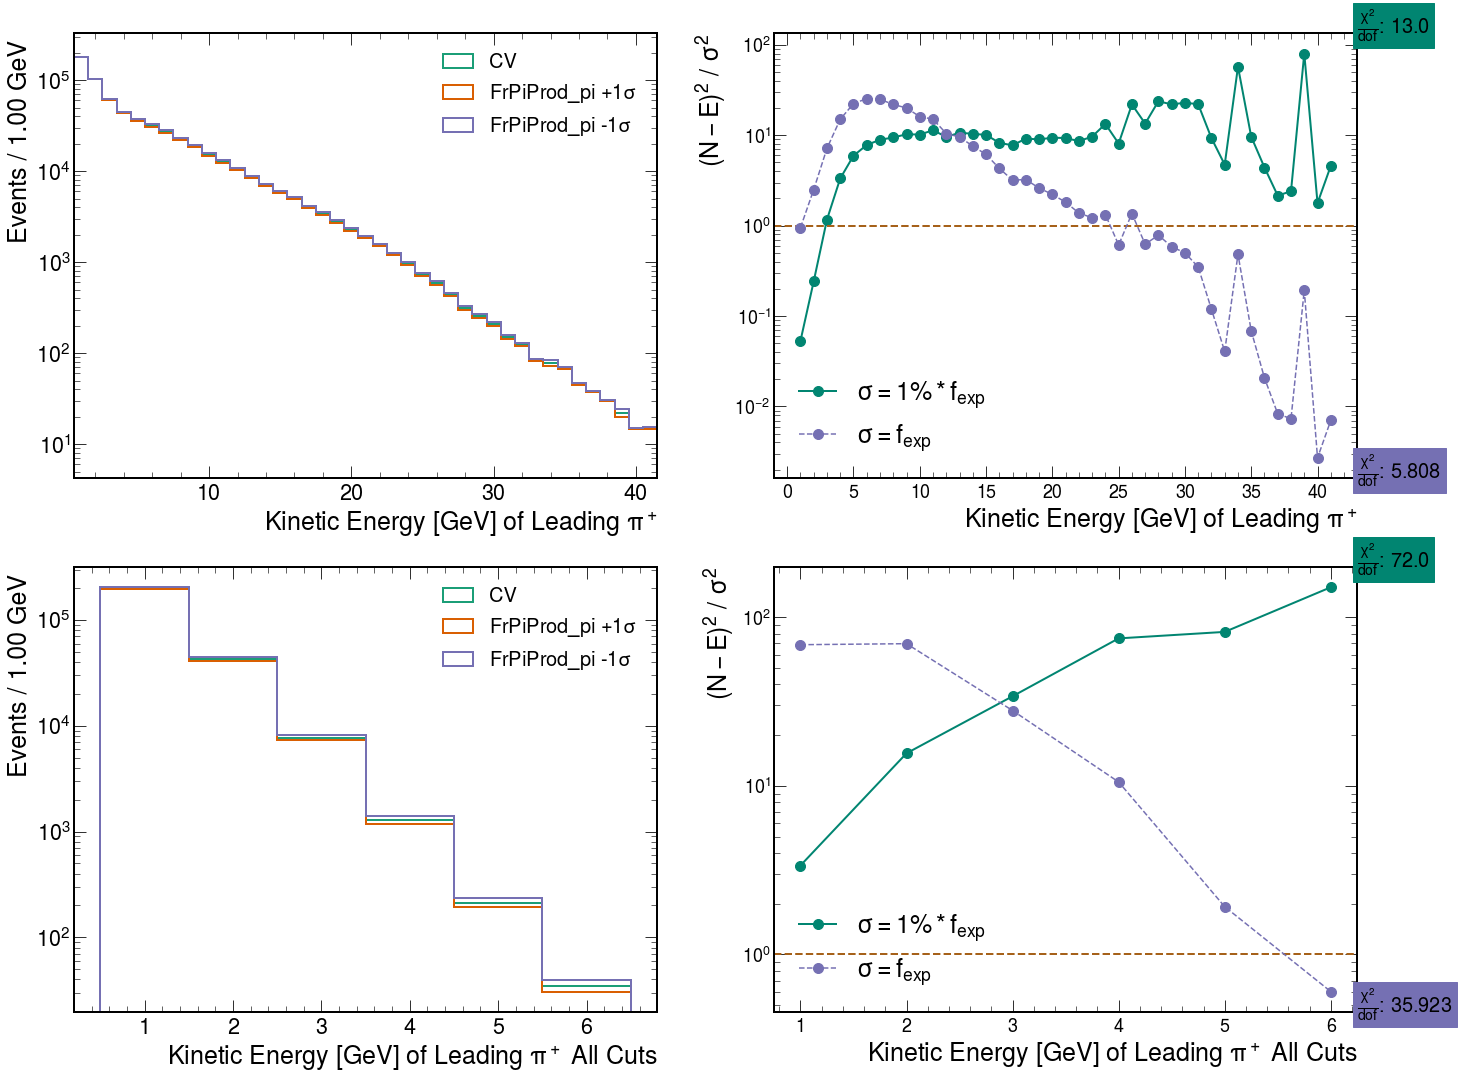

In [133]:
## EXAMPLE: KE Leading ##
par = 2112
ax1, ax2, ax3, ax4 = plot_all(leading_df.query('pdgf == %s'%(par)), leading_cuts_df.query('pdgf == %s'%(par)), 
                              'Count', 'FrPiProd_pi', 'Kinetic Energy [GeV] of Leading $\pi^+$', 2212, isSave = False)

# Plot and Save Everything 

In [16]:
titleDict = {'kef':'Kinetic Energy [GeV] of ', 'kef_l': 'Kinetic Energy [GeV] of Leading ',
             'cthf':'cos($\\theta$) of ', 'cthf_l':'cos($\\theta$) of Leading', 'Count':'Multiplicity of ',
             '211': '$\pi^+$', '-211': '$\pi^-$', '111':'$\pi^0$', '2112':'Neutons', '2212': 'Protons'
            }

In [149]:
wghts = np.array(['FrCEx_N', 'FrAbs_N', 'FrInel_N', 'FrPiProd_N', 'FrCEx_pi', 'FrAbs_pi', 'FrInel_pi', 'FrPiProd_pi'])
#quals = np.array(['KE No Cuts', 'KE All Cuts', 'KE Leading No Cuts', 'KE Leading All Cuts', 'Counts No Cuts', 
                  #'Counts All Cuts', 'Cthf No Cuts', 'Cthf All Cuts'])
pars = np.array([2112, 2212, 211, 111, -211])

In [150]:
quals = np.array(['kef', 'kef_l', 'Count', 'cthf', 'cthf_l'])
arr = []
arr_cuts = []

for wght in wghts:
    for qual in quals:
        for par in pars:
            
            # Contains leading 
            if(qual.find('l') != -1 or qual == 'Count'):
                plot_all(leading_df.query('pdgf == %s'%(par)), leading_cuts_df.query('pdgf == %s'%(par)), 
                         qual, wght, '%s %s'%(titleDict.get(qual), titleDict.get(str(par))),par)
  
                arr.append(find_chisquared(leading_df.query('pdgf == %s'%(par)), qual.split('_')[0], wght))
                arr_cuts.append(find_chisquared(leading_cuts_df.query('pdgf == %s'%(par)), qual.split('_')[0], 
                                                wght))
                
            else:
                plot_all(gst_all_fp.query('pdgf == %s'%(par)), gst_all_cuts.query('pdgf == %s'%(par)), 
                         qual, wght, '%s%s'%(titleDict.get(qual), titleDict.get(str(par))) ,par)
                
                arr.append(find_chisquared(gst_all_fp.query('pdgf == %s'%(par)), qual, wght))
                arr_cuts.append(find_chisquared(gst_all_cuts.query('pdgf == %s'%(par)), qual, wght))
                
    print('Done with: ', wght)
arr = np.array(arr)     
arr_cuts = np.array(arr_cuts)  

Done with:  FrCEx_N
Done with:  FrAbs_N
Done with:  FrInel_N
Done with:  FrPiProd_N
Done with:  FrCEx_pi
Done with:  FrAbs_pi
Done with:  FrInel_pi
Done with:  FrPiProd_pi


# Table of All Chi Squared Values

In [143]:
wghts = np.array([ 'FrAbs N', 'FrAbs pi','FrCEx N', 'FrCEx pi', 'FrInel N', 'FrInel pi','FrPiProd N', 'FrPiProd pi'])
#quals = np.array(['KE No Cuts', 'KE All Cuts', 'KE Leading No Cuts', 'KE Leading All Cuts', 'Counts No Cuts', 
                  #'Counts All Cuts', 'Cthf No Cuts', 'Cthf All Cuts'])
quals = np.array([ 'Multiplicity', 'cos(theta)', 'Leading cos(theta)', 'Kinetic Energy', 'Kinetic Energy Leading'])
pars = np.array([-211, 111, 211, 2112, 2212])

wghts_rs = np.resize(wghts, (np.shape(quals)[0]*np.shape(pars)[0], np.shape(wghts)[0])).T.flatten()
pars_rs = np.resize(pars,(np.shape(quals)[0]*np.shape(wghts)[0], np.shape(pars)[0])).flatten()

quals_rs = np.resize(quals, (np.shape(pars)[0], np.shape(quals)[0])).T.flatten()
quals_rs_rs = np.resize(quals_rs, (np.shape(wghts)[0], np.shape(quals_rs)[0])).flatten().flatten()


mi = pd.MultiIndex.from_arrays([wghts_rs, quals_rs_rs, pars_rs])
df_new = mi.to_frame()
pd.set_option('display.max_rows', None)
df_new = df_new.drop(columns=[0, 1, 2])

In [26]:
import matplotlib.colors as col

colors2 = {'KE': 'white', 'KE Leading':'mistyrose', 'Counts': 'salmon',
          'cos(theta)': 'tomato', 'cos(theta) Leading': 'firebrick'}

c2 = {k:col.rgb2hex(v) for k, v in colors2.items()}
idx2 = df_new.index.get_level_values(1)

css2 = [{'selector': f'.row{i}.level1','props': [('background-color', c2[v])]}
             for i,v in enumerate(idx2)]

colors = {'FrCEx_N': 'lightyellow', 'FrAbs_N':'lemonchiffon' , 'FrInel_N': 'papayawhip', 
          'FrPiProd_N': 'bisque', 'FrCEx_pi': 'wheat', 'FrAbs_pi': 'tan', 
          'FrInel_pi': 'darkgoldenrod', 'FrPiProd_pi': 'goldenrod'}

c = {k:col.rgb2hex(v) for k, v in colors.items()}
idx = df_new.index.get_level_values(0)

css = [{'selector': f'.row{i}.level0','props': [('background-color', c[v])]}
             for i,v in enumerate(idx)]
#df_new.style.set_table_styles(css + css2)

In [140]:
quals = np.array([ 'Count', 'cthf', 'cthf_l', 'kef', 'kef_l'])
arr = []
arr_cuts = []

for wght in wghts:
    for qual in quals:
        for par in pars:
            
            # Contains leading 
            if(qual.find('l') != -1 or qual == 'Count'):
                arr.append(find_chisquared(leading_df.query('pdgf == %s'%(par)), qual.split('_')[0], wght))
                arr_cuts.append(find_chisquared(leading_cuts_df.query('pdgf == %s'%(par)), 
                                                qual.split('_')[0], wght))
            else:
                arr.append(find_chisquared(gst_all_fp.query('pdgf == %s'%(par)), qual, wght))
                arr_cuts.append(find_chisquared(gst_all_cuts.query('pdgf == %s'%(par)), 
                                                qual, wght))
    print('Done with: ', wght)
arr = np.array(arr)           

Done with:  FrAbs_N
Done with:  FrAbs_pi
Done with:  FrCEx_N
Done with:  FrCEx_pi
Done with:  FrInel_N
Done with:  FrInel_pi
Done with:  FrPiProd_N
Done with:  FrPiProd_pi


In [144]:
df_new['No_Cut_0.01%_Error'] = arr[::,0]
df_new['No_Cut_Normal_Error'] = arr[::,1]

arr_cuts = np.array(arr_cuts)
df_new['Cuts_0.01%_Error'] = arr_cuts[::,0]
df_new['Cuts_Normal_Error'] = arr_cuts[::,1]

In [145]:
df_new

No_Cut_0.01%_Error  No_Cut_Normal_Error  \
FrAbs N     Counts             -211            21.223032           125.331514   
                                111            18.908641           107.990761   
                                211            18.857403           100.167540   
                                2112           77.701532            75.349940   
                                2212           69.679480            63.521867   
            cos(theta)         -211            23.852615            21.432444   
                                111            25.494377            29.189953   
                                211            25.793808            19.851215   
                                2112          102.039429          1035.262932   
                                2212           95.180050           867.063610   
            cos(theta) Leading -211            24.409703            16.004497   
                                111            26.574705            20.632843   
                                211            26.402848            16.091218   
                                2112           67.018844           103.110048   
                                2212           56.425307            81.304922   
            KE                 -211            13.863898            22.218096   
                                111            17.399829            32.601319   
                                211            15.619847            24.572378   
                                2112            8.526915          1200.888539   
                                2212            7.261648          1033.344031   
            KE Leading         -211            13.923308            18.165547   
                                111            17.707218            23.419106   
                                211            15.775895            20.219970   
                                2112            7.443780           126.186078   
                                2212            5.760909           101.909806   
FrAbs pi    Counts             -211           247.165981           895.543718   
                                111           262.652502           972.699304   
                                211           261.363106           808.479275   
                                2112          239.373079           279.888494   
                                2212          213.254483           257.215608   
            cos(theta)         -211           172.697120           178.463427   
                                111           274.461353           322.094700   
                                211           191.885078           168.857498   
                                2112          188.031264          2132.061332   
                                2212          169.588226          1718.104605   
            cos(theta) Leading -211           145.073361           103.596931   
                                111           219.768552           176.123701   
                                211           163.382219           114.555954   
                                2112          158.245004           301.404461   
                                2212          137.270498           260.442126   
            KE                 -211            69.142259           198.510064   
                                111            96.646859           387.585590   
                                211            91.727288           241.801477   
                                2112          120.854214          2418.143588   
                                2212          108.339006          2040.811541   
            KE Leading         -211            66.806652           136.521251   
                                111            94.583122           222.533606   
                                211            89.524381           168.263750   
                                2112          112.974739           40

In [146]:
print(df_new.to_latex())

\begin{tabular}{lllrrrr}
\toprule
            &            &       &  No\_Cut\_0.01\%\_Error &  No\_Cut\_Normal\_Error &  Cuts\_0.01\%\_Error &  Cuts\_Normal\_Error \\
\midrule
FrAbs N & Counts & -211  &           21.223032 &           125.331514 &         16.651866 &          50.181491 \\
            &            &  111  &           18.908641 &           107.990761 &         13.313707 &          51.290846 \\
            &            &  211  &           18.857403 &           100.167540 &         15.845069 &          49.028353 \\
            &            &  2112 &           77.701532 &            75.349940 &         28.192635 &         140.730446 \\
            &            &  2212 &           69.679480 &            63.521867 &         18.817757 &         115.688004 \\
            & cos(theta) & -211  &           23.852615 &            21.432444 &         16.097855 &           5.439405 \\
            &            &  111  &           25.494377 &            29.189953 &         16.969460 &

In [121]:
df_new_styled = df_new[:100].style.set_table_styles(css + css2)
import dataframe_image as dfi
dfi.export(df_new_styled, 'dataframe.png')

In [104]:
#df_new_cut = df_new[df_new['No_Cut_0.01%_Error'] > 1]
#display(df_new_cut)
df_new_cut.style.set_table_styles(css + css2)